[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
  
def linf_distance((a,b),(x,y)):
  return max(abs(a-x),abs(b-y))
def l1_distance((a,b),(x,y)):
  return abs(a-x)+abs(b-y)
def displacement(initial,terminal):
  return (terminal[0]-initial[0], terminal[1]-initial[1])
def get_coordinates(array):
  return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
  
class Agents:
  
  def __init__(self,L=5,scale=5):
    self.grid_shape = (scale*L, scale*L)
    
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    template_array = np.zeros(self.grid_shape)
    template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    self.template_coordinates = get_coordinates(template_array)
    self.agent_coordinates = get_coordinates(agents_array)
    
    self.activity = [True for _ in self.agent_coordinates]
    self.activity[-1] = False # source agent
    
    self.direction = [(1,0) for _ in self.agent_coordinates]
    
    self.update_neighbors()
    self.gradient = []
    prod = [i*j for (i,j) in self.agent_coordinates]
    maxprod = max(prod)
    self.is_source = [bool(p == maxprod) for p in prod]
    self.update_gradient() 
    
    self.logstr = []
    self.logarray = []
    self.update_logarray()
    
  def make_grid(self,highlight_agents_by_index=[],contrast=0.666,gradient=True):
    grid = np.zeros(self.grid_shape)
    for p in self.template_coordinates:
      grid[p]=1-contrast
      
    if gradient:
      max_gradient = max(self.gradient)
      for i,p in enumerate(self.agent_coordinates):
        grid[p] = 1+ contrast*(1 - float(max_gradient - self.gradient[i] + 1)/max_gradient)
    else:
      for p in self.agent_coordinates:
        grid[p] = 1
        
    for i in highlight_agents_by_index:
      grid[self.agent_coordinates[i]] = 1+2*contrast
    return grid
    
  def plot(self,t=-1):
    grid = self.logarray[t]
    plt.imshow(grid)
    plt.grid(False)
    plt.show()
  
  def update_neighbors(self):
    def get_neighbors(i):
      p0 = self.agent_coordinates[i]
      return [j for j,p in enumerate(self.agent_coordinates) if linf_distance(p0,p)==1 and i!=j]
    
    self.neighbors = [get_neighbors(i) for i in range(len(self.agent_coordinates))]
  
  def edgefollows(self,i):
    def surroundings(i):
      (x0,y0) = self.agent_coordinates[i]
      coordinates = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y0),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
      ans = [{'coordinates': (x,y),
              'is_unoccupied': (x,y) not in self.agent_coordinates,
              'is_in_template': (x,y) in self.template_coordinates,
              'is_in_grid': x in range(self.grid_shape[0]) and y in range(self.grid_shape[1])} for (x,y) in coordinates]
      return ans
    surr = surroundings(i)
    o = [s['is_unoccupied'] for s in surr]
    ans = []
    for k in range(8):
      o0, o1, o2, o3, o4, o5, o6, o7 = o[(k+0)%8], o[(k+1)%8], o[(k+2)%8], o[(k+3)%8], o[(k+4)%8], o[(k+5)%8], o[(k+6)%8], o[(k+7)%8]
      x0, x1, x2, x3, x4, x5, x6, x7 = not o0, not o1, not o2, not o3, not o4, not o5, not o6, not o7
      if o0 and o1 and o2 and o3:
        if x4 and x5 and x6 and x7:
          #  x  x  x
          #  x     o*
          #  o* o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+3)%8]['coordinates']]
          break
        elif o4 and x5 and x6 and x7:
          #  x  x  o*   x  x  x
          #  x     o    o*    o*
          #  o* o  o    o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
          break
        elif o4 and o5 and x6 and x7:
          #  x  x  o*
          #  o*    o
          #  o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+5)%8]['coordinates']]
          break
        elif o4 and o5 and o6 and x7:
          #  x  o* o
          #  o*    o
          #  o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
      elif o0 and o1 and x3 and x4 and o5 and x6:
        #  o  e  x
        #  o     o*
        #  e  x  x
        ans = [surr[(k+5)%8]['coordinates']]
        break
      elif o0 and x1 and x2 and x3 and o4 and x5 and x6 and x7:
        #  x  x  x
        #  o*    o*
        #  x  x  x
        ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
        break
    surr_in_grid = [s['coordinates'] for s in surr if s['is_in_grid']]
    ans = [p for p in ans if p in surr_in_grid]
    return ans
  
  def neighbor_gradient_max(self,i):
    return max([self.gradient[j] for j in self.neighbors[i]])
  def update_gradient(self):
    self.gradient = ['' for _ in self.agent_coordinates]
    i_source = self.is_source.index(True)
    self.gradient[i_source] = 0
    for j in self.neighbors[i_source]:
      self.gradient[j] = 1
    while '' in self.gradient:
      for i,g in enumerate(self.gradient):
        if g=='':
          min_gradient_in_neighbors = 10**10 # big number
          should_assign_gradient_value = False
          for j in self.neighbors[i]:
            if self.gradient[j] != '':
              min_gradient_in_neighbors = min(self.gradient[j],min_gradient_in_neighbors)
              should_assign_gradient_value = True
          if should_assign_gradient_value:
            self.gradient[i] = 1+min_gradient_in_neighbors
    
  def update_activity_direction_coordinates(self,i):
    def prospective_location(i):
      (x0,y0) = self.agent_coordinates[i]
      (dx,dy) = self.direction[i]
      (x,y) = (x0+dx,y0+dy)
      return (x,y)
    def choose(plist):
      def linf_distance_to_template(p):
        return min([linf_distance(p,t) for t in self.template_coordinates])
      def angle(i,p):
        p_direction = displacement(self.agent_coordinates[i],p)
        return l1_distance(self.direction[i],p_direction)
      if len(plist) == 1:
        return plist[0]
      elif len(plist) >= 2:
        angles = [angle(i,p) for p in plist]
        leastangle = min(angles)
        plist = [plist[j] for j,a in enumerate(angles) if a==leastangle]
        if len(plist) == 1:
          return plist[0]
        else:
          distances = [linf_distance_to_template(p) for p in plist]
          leastdist = min(distances)
          plist = [plist[j] for j,d in enumerate(distances) if d==leastdist]
          if len(plist) == 1:
            return plist[0]
          elif len(plist) >= 2:
            return random.choice(plist)
    def update_activity(i):
      if self.activity[i]:
        p0 = self.agent_coordinates[i]
        p = prospective_location(i)
        if p0 in self.template_coordinates: # if inside the shape
          if p not in self.template_coordinates: # turn off if moving forward would leave the shape
            self.activity[i] = False
#          elif # turn off if has neighbor with same gradient value
    
    update_activity(i)
    if self.activity[i]: # forward edge-follow
      p = prospective_location(i)
      plist = self.edgefollows(i)
      if p in plist:
        self.agent_coordinates[i] = p
      elif len(plist)>0: # turn & edge-follow
        p = choose(plist)
        self.direction[i] = displacement(self.agent_coordinates[i],p)
        update_activity(i)
        if self.activity[i]:
          self.agent_coordinates[i] = p
    self.update_gradient()
  
  def update_logarray(self,highlight_agents_by_index=[],contrast=0.666):
    grid = self.make_grid(highlight_agents_by_index=highlight_agents_by_index,contrast=contrast)
    self.logarray.append(grid)
  
  def timestep(self,computation='parallel',log=True):
    def update_logstr(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0):
      def arrow(direction):
        # arrows: http://xahlee.info/comp/unicode_arrows.html
        arrowdict = {'(-1, 0)':'🡑',
                    '(-1, 1)':'🡕',
                    '(0, 1)':'🡒',
                    '(1, 1)':'🡖',
                    '(1, 0)':'🡓',
                    '(1, -1)':'🡗',
                    '(0, -1)':'🡐',
                    '(-1, -1)':'🡔'}
        return arrowdict[str(direction)]
      dir0, dir1 = arrow(dir0), arrow(dir1)
      translation_dict = {True:'on',False:'off'}
      activity0, activity1 = translation_dict[activity0], translation_dict[activity1]
      template_string = 'Agent {0}: [{1},{2},{3},{7},{8}]-->[{4},{5},{6}]'
      newstring = template_string.format(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
      self.logstr.append(newstring)
    def move(i):
      orig_coordinates = self.agent_coordinates[i]
      self.update_activity_direction_coordinates(i)
      self.update_neighbors()
      if self.agent_coordinates[i] == orig_coordinates:
        return False
      else:
        return True
      
    subset = [i for i,a in enumerate(self.activity) if len(self.edgefollows(i))>0 and a==True]
    random.shuffle(subset)
    if computation=='parallel':
      for i in subset:
        if log:
          p0 = self.agent_coordinates[i]
          dir0 = self.direction[i]
          activity0 = self.activity[i]
          neighbors0 = '_'.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
          edgefollows0 = '_'.join([str(e) for e in self.edgefollows(i)])
          move(i)
          p1 = self.agent_coordinates[i]
          dir1 = self.direction[i]
          activity1 = self.activity[i]
          update_logstr(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
          #self.update_logarray(highlight_agents_by_index=[i])
          self.update_logarray()
        else:
          move(i)
    elif computation=='series':
      for i in [random.choice(subset)]:
        ans = True
        while ans:
          if log:
            p0 = self.agent_coordinates[i]
            dir0 = self.direction[i]
            activity0 = self.activity[i]
            neighbors0 = '_'.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
            edgefollows0 = '_'.join([str(e) for e in self.edgefollows(i)])
            ans = move(i)
            p1 = self.agent_coordinates[i]
            dir1 = self.direction[i]
            activity1 = self.activity[i]
            update_logstr(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)  
            #self.update_logarray(highlight_agents_by_index=[i])
            self.update_logarray()
          else:
            move(i)
            
  def run(self,max_iter=1000,log_every=10):
    counter = 0
    tenth = int(float(max_iter)/10)
    tenths = 0
    print 'running...'
    while counter < max_iter:
      log = False
      if counter % log_every == 0:
        log=True
      if counter % tenth == 0:
        print('       ...'+str(tenths*10)+'%')
        tenths += 1
      a.timestep(computation='parallel',log=log)
      counter += 1
      if set(a.agent_coordinates) == set(a.template_coordinates):
        self.update_logarray()
        print 'SUCCESS'
        break
      if counter == max_iter:
        print 'reached max iterations'

In [76]:
a = Agents(L=10)
a.run(max_iter=500,log_every=50)

running...
       ...0%
       ...10%
       ...20%
       ...30%
       ...40%
SUCCESS


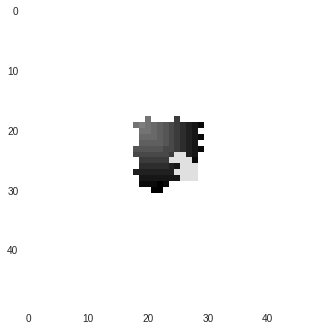

In [79]:
a.plot(-5)